# 循环神经网络

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.keras import layers, Model, Input

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(gpu)
except RuntimeError as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 序列
具有先后顺序的数据一般叫作序列(Sequence). 我们把文字编码为数值的过程叫作**Word Embedding**.

one-hot编码的优缺点:
- 简单直观，编码过程不需要学习和训练;
- 但高维度而且极其稀疏的，大量的位置为0，计算效率较低, 忽略了单词先天具有的语义相关性;

余弦相关度(Cosine similarity), 衡量词向量(word vector)之间相关度:
$$similarity(a, b) \triangleq \frac {a \cdot b}{|a|\cdot|b|}$$

### Embedding层
单词的表示层叫作Embedding层, 负责把单词编码为某个词向量𝒗

$$v = f_{\theta}(i|N_{vocab}, n)$$
单词数量记为$N_{vocab}$, $v的长度为n$, $i$表示单词编号, 如2 表示“I”，3 表示“me”等.

In [4]:
x = tf.range(10)  # 代表10个不同单词的编码

x = tf.random.shuffle(x)
# 10个单词, 每个单词用长度4 的向量表示
net = layers.Embedding(10, 4)
out = net(x)
out

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.00574332,  0.02812352,  0.04669685,  0.0391869 ],
       [-0.01434119,  0.02572837,  0.04958155, -0.04431714],
       [ 0.03518841, -0.01115884, -0.01963706,  0.00121148],
       [ 0.00390678, -0.02173036, -0.02869215, -0.02330655],
       [-0.00665484,  0.02177354,  0.02495729,  0.01703597],
       [-0.00748539, -0.02535394,  0.0444125 ,  0.01612288],
       [-0.02111974, -0.0085175 , -0.01128819,  0.0151321 ],
       [-0.01652012,  0.03961059, -0.01084927,  0.04935564],
       [-0.0225154 , -0.02152805, -0.02919455,  0.04838732],
       [-0.00428147,  0.0036455 ,  0.04103759,  0.03278683]],
      dtype=float32)>

In [5]:
net.get_weights()

[array([[-0.00665484,  0.02177354,  0.02495729,  0.01703597],
        [-0.00574332,  0.02812352,  0.04669685,  0.0391869 ],
        [-0.0225154 , -0.02152805, -0.02919455,  0.04838732],
        [-0.01434119,  0.02572837,  0.04958155, -0.04431714],
        [-0.00748539, -0.02535394,  0.0444125 ,  0.01612288],
        [ 0.03518841, -0.01115884, -0.01963706,  0.00121148],
        [-0.02111974, -0.0085175 , -0.01128819,  0.0151321 ],
        [-0.01652012,  0.03961059, -0.01084927,  0.04935564],
        [ 0.00390678, -0.02173036, -0.02869215, -0.02330655],
        [-0.00428147,  0.0036455 ,  0.04103759,  0.03278683]],
       dtype=float32)]

### 预训练的词向量

应用的比较广泛的预训练模型:Word2Vec 和GloVe模型.利用已预训练好的模型参数初始化Embedding层.

In [6]:
def load_embed(path):
    # 建立映射关系: 单词: 词向量(长度50))
    embedding_map = {}
    with open(path, encoding='utf8') as f:
        for line in f.readlines():
            l = line.split()
            word = l[0]
            coefs = np.asarray(l[1:], dtype='float32')
            embedding_map[word] = coefs
    return embedding_map

In [7]:
embedding_map = load_embed('glove.6B.50d.txt')
print('Found %s word vectors.' % len(embedding_map))

Found 400000 word vectors.


In [8]:
embedding_map['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

### 20newsgroups 测试

In [9]:
from sklearn import datasets
# 加载20newsgroups数据集
news20 = datasets.fetch_20newsgroups()

In [10]:
news20.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [11]:
category = news20.target_names  # 一共20类不同的新闻
category

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [12]:
labels = news20['target']  # 每条新闻分属的类别

In [13]:
len(news20['data'])

11314

In [14]:
news20['data'][0], category[news20['target'][0]]

("From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 'rec.autos')

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [16]:
MAX_NUM_WORDS = 20000  # 最多保留 20000-1 个不同的单词
MAX_SEQUENCE_LENGTH = 1000  # 每个序列长度
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 50  # 用50维向量表示一个单词

In [17]:
Tokenizer?

Init signature:
Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    document_count=0,
    **kwargs,
)
Docstring:     
Text tokenization utility class.

This class allows to vectorize a text corpus, by turning each
text into either a sequence of integers (each integer being the index
of a token in a dictionary) or into a vector where the coefficient
for each token could be binary, based on word count, based on tf-idf...

# Arguments
    num_words: the maximum number of words to keep, based
        on word frequency. Only the most common `num_words-1` words will
        be kept.
    filters: a string where each element is a character that will be
        filtered from the texts. The default is all punctuation, plus
        tabs and line breaks, minus the `'` character.
    lower: boolean. Whether to convert the texts to lowercase.
    split: str. Separator for word splitting.
    c

In [18]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)  #  Only the most common `num_words-1` words will be kept.

In [19]:
# Updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(news20['data'])
sequences = tokenizer.texts_to_sequences(news20['data'])  # 语句 -> 单词序列号组成的sequences

In [20]:
# matrix = tokenizer.texts_to_matrix(news20['data'])
# matrix.shape  # (11314, 20000)  稀疏矩阵

In [21]:
sequences[0]

[14,
 4308,
 1350,
 15,
 11126,
 38,
 250,
 29,
 42,
 298,
 9,
 17,
 95,
 78,
 91,
 4308,
 1350,
 15,
 34,
 77,
 3,
 2952,
 610,
 1767,
 32,
 211,
 8,
 26,
 1308,
 27,
 171,
 66,
 47,
 123,
 9879,
 63,
 16,
 17,
 298,
 8,
 708,
 1,
 86,
 263,
 11,
 26,
 4,
 36,
 1497,
 2266,
 298,
 1162,
 2,
 18,
 14,
 1,
 1347,
 13637,
 843,
 15448,
 11,
 26,
 337,
 4,
 1,
 4017,
 80,
 182,
 484,
 7,
 1376,
 1,
 844,
 8164,
 26,
 1835,
 14,
 1,
 816,
 3,
 1,
 726,
 17,
 9,
 44,
 8,
 88,
 27,
 171,
 39,
 4,
 828,
 273,
 1078,
 2908,
 198,
 3,
 2804,
 153,
 17,
 298,
 9,
 239,
 628,
 25,
 808,
 357,
 13,
 21,
 16,
 17,
 384,
 298,
 181,
 112,
 188,
 206,
 1498,
 1341,
 2,
 13,
 35,
 58,
 7860]

In [22]:
# 将sequences 转成文本list
# tokenizer.sequences_to_texts(sequences)

In [23]:
# 将单词映射为 index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index_list = list(word_index.items())

Found 134142 unique tokens.


In [24]:
# 从1开始编码 用0代表填充
word_index_list[:10]  # news20group 出现频率最高的10个单词

[('the', 1),
 ('to', 2),
 ('of', 3),
 ('a', 4),
 ("'ax", 5),
 ('and', 6),
 ('in', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10)]

In [25]:
word_index_list[19998]

('amsat', 19999)

In [26]:
# Pads sequences to the same length.
pad_sequences?

Signature:
pad_sequences(
    sequences,
    maxlen=None,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0.0,
)
Docstring:
Pads sequences to the same length.

This function transforms a list of
`num_samples` sequences (lists of integers)
into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
`num_timesteps` is either the `maxlen` argument if provided,
or the length of the longest sequence otherwise.

Sequences that are shorter than `num_timesteps`
are padded with `value` at the end.

Sequences longer than `num_timesteps` are truncated
so that they fit the desired length.
The position where padding or truncation happens is determined by
the arguments `padding` and `truncating`, respectively.

Pre-padding is the default.

# Arguments
    sequences: List of lists, where each element is a sequence.
    maxlen: Int, maximum length of all sequences.
    dtype: Type of the output sequences.
        To pad sequences with variable length strings, you can use `obje

In [27]:
# 每条新闻都被编码成 等长的 用数字表示的 序列
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
data.shape

(11314, 1000)

In [29]:
np.max(data), np.min(data) # 

(19999, 0)

In [30]:
from sklearn.model_selection import train_test_split

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=VALIDATION_SPLIT, random_state=0) 

In [31]:
X_train.shape, y_test.shape

((9051, 1000), (2263,))

In [32]:
# 将 单词序号-> 单词向量(长度50)
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    # 根据glove.6B.50d 将单词转为词向量
    embedding_vector = embedding_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
# new20group中最常用的19999 词向量 + 填充 + unknow
embedding_matrix.shape

(20001, 50)

In [34]:
embedding_matrix[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
layers.Embedding?

Init signature:
layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used as the first layer in a model.

Example:

```python
model = Sequential()
model.add(Embedding(1000, 64, input_length=10))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
assert output_array.shape == (32, 10, 64)
```

Arguments:
  in

In [36]:
embedding_layer = layers.Embedding(
    num_words, EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [41]:
sequence_input = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
embedded_sequences = embedding_layer(sequence_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
preds = layers.Dense(len(category), activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          1000050   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048 

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [42]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_test, y_test))

Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 7s 813us/sample - loss: 2.5939 - accuracy: 0.1699 - val_loss: 2.0294 - val_accuracy: 0.2757
Epoch 2/30
9051/9051 [==============================] - 7s 750us/sample - loss: 1.7311 - accuracy: 0.4000 - val_loss: 1.5560 - val_accuracy: 0.4476
Epoch 3/30
9051/9051 [==============================] - 7s 753us/sample - loss: 1.3698 - accuracy: 0.5102 - val_loss: 1.3469 - val_accuracy: 0.5201
Epoch 4/30
9051/9051 [==============================] - 7s 747us/sample - loss: 1.1312 - accuracy: 0.6015 - val_loss: 1.1927 - val_accuracy: 0.5802
Epoch 5/30
9051/9051 [==============================] - 7s 736us/sample - loss: 0.9398 - accuracy: 0.6713 - val_loss: 1.0953 - val_accuracy: 0.6120
Epoch 6/30
9051/9051 [==============================] - 7s 735us/sample - loss: 0.7888 - accuracy: 0.7271 - val_loss: 1.0019 - val_accuracy: 0.6558
Epoch 7/30
9051/9051 [==============================] - 7s 740us

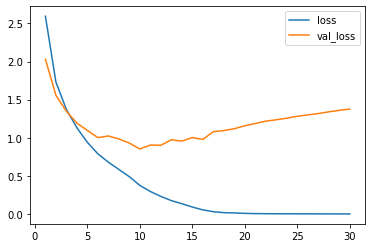

In [45]:
plt.plot(np.linspace(1, 30, 30), hist.history['loss'], label='loss')
plt.plot(np.linspace(1, 30, 30), hist.history['val_loss'], label='val_loss')
plt.legend()

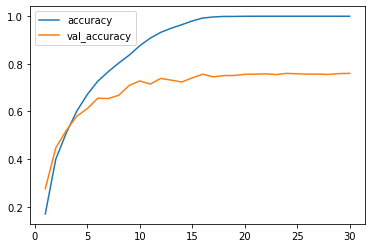

In [46]:
plt.plot(np.linspace(1, 30, 30), hist.history['accuracy'], label='accuracy')
plt.plot(np.linspace(1, 30, 30), hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

## 循环神经网络


$$h_t = \sigma(W_{xh}x_t + W_{hh}h_{t-1} + b)$$
在每个时间戳$t$, 网络层接受当前时间戳的输入$x_t$和上一个时间戳的网络状态向量$h_{t-1}$,经过
$$h_t = f_{\theta}(h_{t-1}, x_t)$$
变换后得到当前时间戳的新状态向量$h_t$. 在每个时间戳上, 网络层均有输出$o_t = g_{\phi}(h_t)$

对于这种网络结构，我们把它叫做循环网络结构(Recurrent Neural Network，简称RNN)。